In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import glob
import tqdm
from typing import List, Tuple, Optional, Union
from src.utils.blockwise_diag_matricies import BlockwiseDiagMatrix

In [11]:
class Wrapper(nn.Module):
    def __init__(self, n_experts:int,
                 d : int,
                 rank: int,
                 eps:float=1e-4):
        
        super(Wrapper, self).__init__()
        self.n_experts = n_experts
        self.d = d
        self.rank = rank
        
        self.A = nn.Parameter(torch.randn(n_experts, d, rank) / (rank ** 0.5))
        self.B = nn.Parameter(torch.zeros(n_experts, rank, d))
        
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError("Use matmul operator '@' instead of forward method.")
    
    def __matmul__(self, core: torch.Tensor) -> torch.Tensor:
        #wrapper @ core 
        #multiply core with B2, then permute, then multiply with B1
        #if the core is 2d padd it to 3d
        if core.dim() == 2:
            core = core.unsqueeze(0)  #shape of (1, d_out, d_in)
        out = self.B @ core  #shape of (n_experts, rank, d_in)
        out = self.A @ out +  core  #shape of (n_experts, d_out, d_in)
        return out
    
    def __rmatmul__(self, core: torch.Tensor) -> torch.Tensor:
        #core @ wrapper 
        #multiply core with A, then permute, then multiply with B
        #if the core is 2d padd it to 3d
        if core.dim() == 2:
            core = core.unsqueeze(0)  #shape of (1, d_out, d_in)
        out = core @ self.A  #shape of (n_experts, d_out, rank)
        out = out @ self.B + core  #shape of (n_experts, d_out, d_in)
        return out
    
    @property
    def params_per_expert(self) -> int:
        return self.d * self.rank * 2
        

In [12]:
d_1,d_2,d_3 = 128, 768, 64


a = torch.randn(d_1, d_2, d_3)

idxs = torch.stack([torch.randperm(d_3) for _ in range(d_1)], dim=0)
a_permuted = a[torch.arange(d_1).unsqueeze(-1), :, idxs]
print(a_permuted.shape)

torch.Size([128, 64, 768])


In [23]:
model = "Qwen/Qwen3-30B-A3B-Base"
layer = 0
proj = "down_proj"
device = torch.device("cuda:7")
weights_paths = glob.glob(f"../LLM_data/{model}/original_weights/layer_{layer}/mlp.expert_*.{proj}.pt")
print("Found n weights:", len(weights_paths))
weights = [torch.load(path, map_location=device)["weight"].to(torch.float32).detach() for path in weights_paths]

hessian_path = "hessian_diag/SlimPajama-627B/n_samples_512_ctx_len_8192/seed_0"
hessian_diags = [
    torch.load(w.replace("original_weights", hessian_path), map_location=device)["hessianDiag"].to(torch.float32) for w in weights_paths
]

Found n weights: 128


In [24]:
class CompressedProj(nn.Module):
    def __init__(self, weights:list[torch.Tensor], hessian_diags:list[torch.Tensor],
                 d_low_rank:int=64,
                 device:torch.device=torch.device("cpu"),
                 eps:float=1e-4):
        super().__init__()
        self.original_weights = nn.Buffer(torch.stack(weights))  # (n_experts, out_dim, in_dim)
        self.hessian_diags = nn.Buffer(torch.stack(hessian_diags))  # (n_experts, in_dim)
        
        #calculate the loss scaling just to make sure that the losses are readable
        self.loss_scaling = torch.sum(self.original_weights**2 * self.hessian_diags.unsqueeze(1),
                                      dim=(1,2), keepdim=True)  #shape (n_experts, 1, 1)
        
        self.wrapper_A = Wrapper(n_experts=self.n_experts,
                                    d=self.d_out,
                                    rank=d_low_rank,
                                    eps=eps)
        self.wrapper_B = Wrapper(n_experts=self.n_experts,
                                    d=self.d_in,
                                    rank=d_low_rank,
                                    eps=eps)
        self.core_weight = nn.Parameter(torch.mean(self.original_weights, dim=0))  # (d_out, d_in)
    
    
    @ property
    def d_in(self) -> int:
        return self.original_weights.shape[2]
    @ property
    def d_out(self) -> int:
        return self.original_weights.shape[1]
    
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.wrapper_B(x) #shape of (..., n_experts, d_core)
        out = F.linear(out.view(-1, self.d_core), self.core_weight).view(*x.shape[:-2], 
                                                                         self.n_experts, self.d_core)
        
        out = self.wrapper_A(out)  #shape of (..., n_experts, d_out)
        return out
    
    @property
    def n_experts(self)->int:
        return self.original_weights.shape[0]
    
    def reconstruct_weight(self)->torch.Tensor:
        return self.wrapper_A @ (self.core_weight @ self.wrapper_B)  # (n_experts, out_dim, in_dim)
    
    def recon_loss(self)->torch.Tensor:
        W_recon = self.reconstruct_weight()
        # print("W_recon:", W_recon)
        # raise NotImplementedError("Debugging print statement added.")
        assert W_recon.shape == self.original_weights.shape, \
            f"Reconstructed weight shape {W_recon.shape} does not match original weight shape {self.original_weights.shape}"
        # print(self.original_weights)
        loss = (W_recon - self.original_weights)**2 * self.hessian_diags.unsqueeze(1) #shape (n_experts, out_dim, in_dim)
        #multiply by hessian diag
        # print("loss shape:", loss.shape)
        # print("loss scaling shape:", self.loss_scaling.shape)
        return torch.sum(loss/self.loss_scaling)/self.n_experts
    
    def get_new_params(self)->int:
        n_params = 0
        n_params += self.core_weight.numel()
        count_wrapper_params = lambda x: sum(p.numel() for p in x.parameters())
        
        n_params += count_wrapper_params(self.wrapper_A)
        n_params += count_wrapper_params(self.wrapper_B)
        return n_params
    
    def get_original_params(self)->int:
        return self.original_weights.numel()
    
    def get_sparsity_factor(self)->float:
        return self.get_new_params()/self.get_original_params()
    
    @property
    def params_per_expert(self) -> int:
        print("here")
        return self.core_weight.numel() + self.wrapper_A.params_per_expert + self.wrapper_B.params_per_expert
        
    @property
    def original_params_per_expert(self) -> int:
        return self.original_weights[0].numel()  
    
    def get_active_sparsity_factor(self) -> float:
        print("params per expert:", self.params_per_expert)
        print("original params per expert:", self.original_params_per_expert)
        return self.params_per_expert / self.original_params_per_expert
        

In [ ]:
test_module = CompressedProj(weights, hessian_diags, device=device, eps=1e-1,
                             d_low_rank=32
                             ).to(device)
print("sparsity factor:", test_module.get_sparsity_factor())
print("active sparsity factor:", test_module.get_active_sparsity_factor())

optimizer = torch.optim.Adam(test_module.parameters(), lr=1e-3)

# optimizer = torch.optim.AdamW(test_module.parameters(), lr=1e-3,
#                               weight_decay=1e-1)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50,
                                                    #    threshold=1e-2)

losses = []
bar = tqdm.tqdm(range(1000), desc="Training")
for step in bar:
    optimizer.zero_grad()
    loss = test_module.recon_loss()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    # scheduler.step(loss)
    bar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])
    

sparsity factor: 0.4661458333333333
here
params per expert: 2293760
original params per expert: 1572864
here
active sparsity factor: 1.4583333333333333


Training:  23%|██▎       | 232/1000 [00:17<00:58, 13.22it/s, loss=0.286, lr=0.001]

In [20]:
recon_weight = test_module.reconstruct_weight().detach()
print(recon_weight)

tensor([[[ 3.5304e-03, -1.7385e-02, -3.6796e-03,  ..., -5.0312e-03,
          -5.9396e-03,  2.6873e-04],
         [ 1.0575e-02,  1.5575e-02, -2.1519e-02,  ...,  1.0448e-02,
           5.6193e-03,  2.7879e-03],
         [ 1.3848e-02,  1.8995e-02,  4.6598e-03,  ...,  8.1495e-03,
           1.1969e-02, -1.8024e-03],
         ...,
         [ 6.0490e-03, -1.0140e-02,  1.0708e-02,  ...,  1.8569e-03,
          -9.7040e-03, -2.7390e-02],
         [ 1.1762e-02,  1.0501e-02,  1.6025e-02,  ...,  3.7747e-03,
          -4.0196e-03,  9.6389e-03],
         [-8.8747e-03, -5.6317e-03, -4.0026e-03,  ...,  3.5177e-03,
          -1.1107e-02,  1.7985e-02]],

        [[-7.5696e-03, -3.4842e-02,  1.5904e-02,  ..., -2.6703e-02,
          -4.8129e-03, -7.6358e-04],
         [ 9.8700e-04, -6.6726e-03,  1.5076e-02,  ...,  2.1503e-02,
          -6.4930e-03,  1.9478e-03],
         [-7.7689e-03,  3.8246e-02,  3.3607e-03,  ...,  3.1647e-04,
           7.3795e-03, -1.1843e-02],
         ...,
         [-1.9200e-02, -4

In [17]:
test_module.original_weights

tensor([[[ 9.7046e-03, -1.2939e-02,  2.0447e-03,  ...,  7.7820e-03,
          -6.7139e-03, -7.2327e-03],
         [ 2.7954e-02, -2.1362e-03, -1.5869e-02,  ...,  1.6357e-02,
          -1.0681e-03, -6.1417e-04],
         [ 2.8320e-02,  2.6489e-02,  1.6602e-02,  ...,  8.6670e-03,
           1.6846e-02, -1.6785e-04],
         ...,
         [ 9.4604e-03, -1.5381e-02,  1.7578e-02,  ...,  2.8687e-02,
          -1.7578e-02, -2.7222e-02],
         [ 3.2715e-02,  1.8799e-02,  1.2939e-02,  ..., -1.1597e-03,
          -1.7929e-03,  8.2016e-04],
         [-2.1240e-02, -1.8799e-02, -7.1411e-03,  ...,  1.1902e-02,
           2.1515e-03,  1.4771e-02]],

        [[-9.6436e-03, -3.9795e-02,  3.9551e-02,  ..., -3.0396e-02,
           2.0752e-03,  2.9419e-02],
         [-1.6212e-05, -3.2715e-02,  8.3008e-03,  ...,  1.3306e-02,
          -1.0254e-02, -1.4893e-02],
         [-8.9722e-03,  3.7354e-02,  1.2817e-03,  ...,  1.1902e-02,
          -4.2725e-03, -1.9531e-02],
         ...,
         [-3.6011e-03, -1

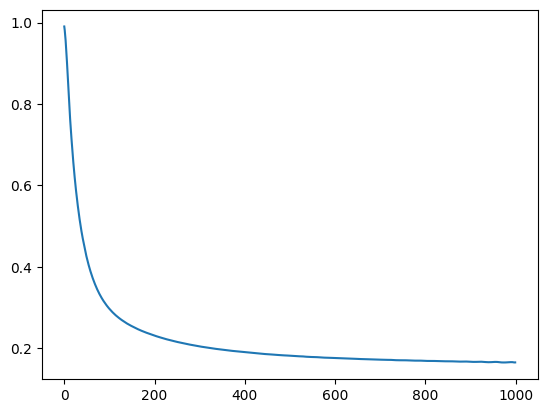

In [22]:
import matplotlib.pyplot as plt
plt.plot(losses)
# plt.yscale("log")
# plt.xscale("log")